## Домашняя работа №2
### Тема: работа с табличными данными в Pandas, контроль качества данных, базовый EDA и визуализация в Matplotlib

#### 1. Загрузка данных и первичный осмотр
Импортируем библиотеки pandas, numpy и matplotlib.pyplot

In [82]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

Прочитаем данные с учебного датасета *S02-hw-dataset.csv* с помощью `pd.read_csv()` и рассмотрим некоторую информацию о датафрейме

In [83]:
dataSet = pd.read_csv(filepath_or_buffer="S02-hw-dataset.csv", sep=",")  # читает csv по пути к файлу или URL, возвращает DataFrame
dataSet.head()  # по умолчанию возвращает первые 5 строк

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [84]:
dataSet.info()  # выводит информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [85]:
dataSet.describe()  # выводит сводное описание датафрейма по столбцам

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


#### 2. Пропуски, дубликаты и базовый контроль качества
Посчитаем долю пропусков в каждом столбце

In [86]:
nullPercent = dataSet .isna().mean()  # .isna() возвращает датафрейм, в котором ячейки принимают значения true/false, где true - пустое значение
# .mean() возвращает среднее значение по столбцам, для булевых True - 1, False - 0
nullPercent = (nullPercent * 100).round(2)  # выведем в процентах с точностью до сотых
nullPercent

user_id      0.00
age          4.88
country      0.00
purchases    0.00
revenue      0.00
dtype: float64

Проверим наличие дубликатов в датафрейме

In [87]:
duplicatesCount = dataSet.duplicated().sum()  # .duplicated() возвращает столбец из флагов True/False
if (duplicatesCount > 0):
    print(f"Количество дубликатов: {duplicatesCount}")

Количество дубликатов: 1


Поиск подозрительных случаев

In [88]:
ageAnomaly = dataSet[(dataSet["age"] < 14) | (dataSet["age"] > 100) | (dataSet["age"].isna())]
# | - побитовое ИЛИ, создает маску (так как каждое сравнение возвращает Series), которая применяется к исходному датафрейму
# мы обращаемся по маске вида 1 False; 2 False; ... 4 True; ... к исходному датафрейму и получаем выборку ошибок(аномалий)
# в данном блоке мы проверяем возраст на промежутке от 15 до 100 (платежеспособность) или на пустое значение

display(ageAnomaly)

,user_id,age,country,purchases,revenue
4,5,NaN,DE,6,1296
5,6,120.0,FR,-1,785
12,13,NaN,US,9,630
20,21,5.0,RU,8,1488


In [89]:
purchasesAnomaly = dataSet[(dataSet["purchases"] < 0)  | 
                           ((dataSet["purchases"] > 0) & (dataSet["revenue"] <= 0))
]
# проверка на отрицательные (нелогичные) значения столбца покупок или на ненулевые покупки с нулевым (отрицательным) доходом
display(purchasesAnomaly)


,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
10,11,24.0,US,4,0


In [90]:
userIDAnomaly = dataSet[
    (dataSet["user_id"] < 0) |
    (dataSet["user_id"].duplicated(keep=False)) |
    (dataSet["user_id"].isna())
]
# проверка на уникальность, существование и допустимое значение (>= 0) для ID пользователя
display(userIDAnomaly)


,user_id,age,country,purchases,revenue
9,10,24.0,RU,7,511
40,10,24.0,RU,7,511


In [91]:
totalAnomalies = len(ageAnomaly) + len(purchasesAnomaly) + len(userIDAnomaly)
print(f"Всего аномалий: {totalAnomalies}")

Всего аномалий: 8


Основные проблемы качетсва данных
1. Полнота: найдено два пустых значения столбца *age*
2. Целостность: ненулевые покупки у пользовтаеля с ID 11 при нулевом доходе (противоречие)
3. Уникальность: обнаружены полные дубликаты строк (2)
4. Валидность: нереалистично высокий возраст (120), отрицательное количество покупок, высокий доход для слишком юного возраста (5)

Вывод:
В данных обнаружены проблемы с качеством: есть пропуски в возрасте, дубликаты пользователей и логические несоответствия. Некоторые значения выглядят нереалистично - например, возраст 120 лет или отрицательное количество покупок.

#### 3. Базовый EDA: группировки, агрегаты и частоты


Посчитаем частоты каждой из стран в столбце *country* 

In [92]:
countries = dataSet["country"].value_counts()  # возвращает количество каждого из значений в столбце country
countries

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Создадим новый столбец возрастной категории *age_group*

In [93]:
ageGroupsSeries = pd.cut(dataSet["age"], bins=[0, 14, 35, 65, 100], labels=["ребенок", "молодой", "средних лет", "пожилой"])
# pandas.cut() разбивает непрерывные числовые интервалы на дискретные интервалы (категории), где bins - границы интервалов, 
# labels - метки для категорий
dataSet["age_group"] = ageGroupsSeries
# создадим в dataSet новый столбец *age_group* и запишем туда значения их ageGroupSeries
display(dataSet.head())


,user_id,age,country,purchases,revenue,age_group
0,1,25.0,FR,7,749,молодой
1,2,24.0,RU,5,1115,молодой
2,3,52.0,FR,7,399,средних лет
3,4,31.0,RU,6,654,молодой
4,5,NaN,DE,6,1296,NaN


Выведем количество пользователей из каждой возрастной категории

In [94]:
ageGroups = dataSet["age_group"].value_counts()
display(ageGroups)

age_group
молодой        22
средних лет    15
ребенок         1
пожилой         0
Name: count, dtype: int64

Разобьем всех пользователей на группы по доходу

In [95]:
revenueGroupsSeries = pd.qcut(dataSet["revenue"], q=4, 
                        labels=["низкий", "средний", "высокий", "очень высокий"])
# Разобьем пользователей на q=4 категории по доходу с помощью pandas.cut()
dataSet["revenue_group"] = revenueGroupsSeries
display(dataSet.head())

,user_id,age,country,purchases,revenue,age_group,revenue_group
0,1,25.0,FR,7,749,молодой,высокий
1,2,24.0,RU,5,1115,молодой,высокий
2,3,52.0,FR,7,399,средних лет,низкий
3,4,31.0,RU,6,654,молодой,средний
4,5,NaN,DE,6,1296,NaN,очень высокий


Выведем количество пользователей каждой категории доходов

In [96]:
revenueGroups = dataSet["revenue_group"].value_counts()
display(revenueGroups)

revenue_group
низкий           11
средний          10
высокий          10
очень высокий    10
Name: count, dtype: int64

Выполним группировку с агрегациями по значениям столбца *age_group*

In [97]:
ageGroup = dataSet.groupby("age_group", observed=False)  # разбивает данные на группы по значениям столбца *age_group*
# выполняем агрегацию (объединение) всех значений по группам по следующим значениям
ageGroup.agg({
    "revenue": ["mean", "sum", "count"],  # находим средний, общий и количество доходов по группам
    "purchases": "mean",  # находим среднее количество покупок по группам
    "age": "mean"  # находим средний возраст по группам
})

revenue              purchases   age
                    mean    sum count      mean  mean
age_group                                            
ребенок      1488.000000   1488     1  8.000000   5.0
молодой       787.954545  17335    22  4.909091  27.0
средних лет   805.866667  12088    15  4.533333  47.0
пожилой              NaN      0     0       NaN   NaN

Создадим столбец среднего чека каждого пользователя

In [98]:
dataSet["avg_check"] = dataSet["revenue"] / dataSet["purchases"]
display(dataSet.head())

,user_id,age,country,purchases,revenue,age_group,revenue_group,avg_check
0,1,25.0,FR,7,749,молодой,высокий,107.0
1,2,24.0,RU,5,1115,молодой,высокий,223.0
2,3,52.0,FR,7,399,средних лет,низкий,57.0
3,4,31.0,RU,6,654,молодой,средний,109.0
4,5,NaN,DE,6,1296,NaN,очень высокий,216.0


Сгруппируем данные по странам и найдем средний чек

In [99]:
countriesGroup = dataSet.groupby("country", observed=False)
countriesGroup.agg({
    "avg_check": "mean"
})

,avg_check
country,
CN,232.000000
DE,223.666667
FR,58.909091
RU,168.545455
US,135.750000


Распределение по группам доходов в разрезе стран

In [100]:
revenueByCountryGroup = dataSet.groupby(["country", "revenue_group"], observed=False)
#  Группируем сначала по странам, а затем по группам доходов
#  observed=False включает все возможные комбинации группировки, даже если в данных их нет
revenueByCountryGroup.agg({
    "user_id": "count",
    "revenue": "mean",
    "purchases": "mean"
})

user_id      revenue  purchases
country revenue_group                                 
CN      низкий               0          NaN        NaN
        средний              1   456.000000   2.000000
        высокий              0          NaN        NaN
        очень высокий        1  1652.000000   7.000000
DE      низкий               0          NaN        NaN
        средний              0          NaN        NaN
        высокий              3   848.000000   4.333333
        очень высокий        3  2043.000000   8.666667
FR      низкий               5   225.600000   2.600000
        средний              2   619.500000   6.500000
        высокий              2   767.000000   3.000000
        очень высокий        3  1403.333333   6.333333
RU      низкий               3   144.000000   1.000000
        средний              5   553.600000   5.400000
        высокий              2  1097.500000   5.500000
        очень высокий        3  1625.333333   7.000000
US      низкий               3   224.000000   4.000000
        средний              2   537.500000   7.000000
        высокий              3   904.000000   3.666667
        очень высокий        0          NaN        NaN

**ВЫВОД**:

Среди пользователей доминируют молодые люди в возрасте до 35 лет, составляющие более половины всей выборки, при этом Россия и Франция являются наиболее представленными странами. Распределение по уровням дохода оказалось практически равномерным. Наблюдаются заметные различия в поведении возрастных групп: пользователи средних лет демонстрируют более стабильные финансовые показатели, в то время как среди молодых пользователей встречаются как очень высокие, так и нулевые значения дохода.

#### 4. Визуализация данных в Matplotlib

Инициализируем фигуру 2x2 и четыре графика

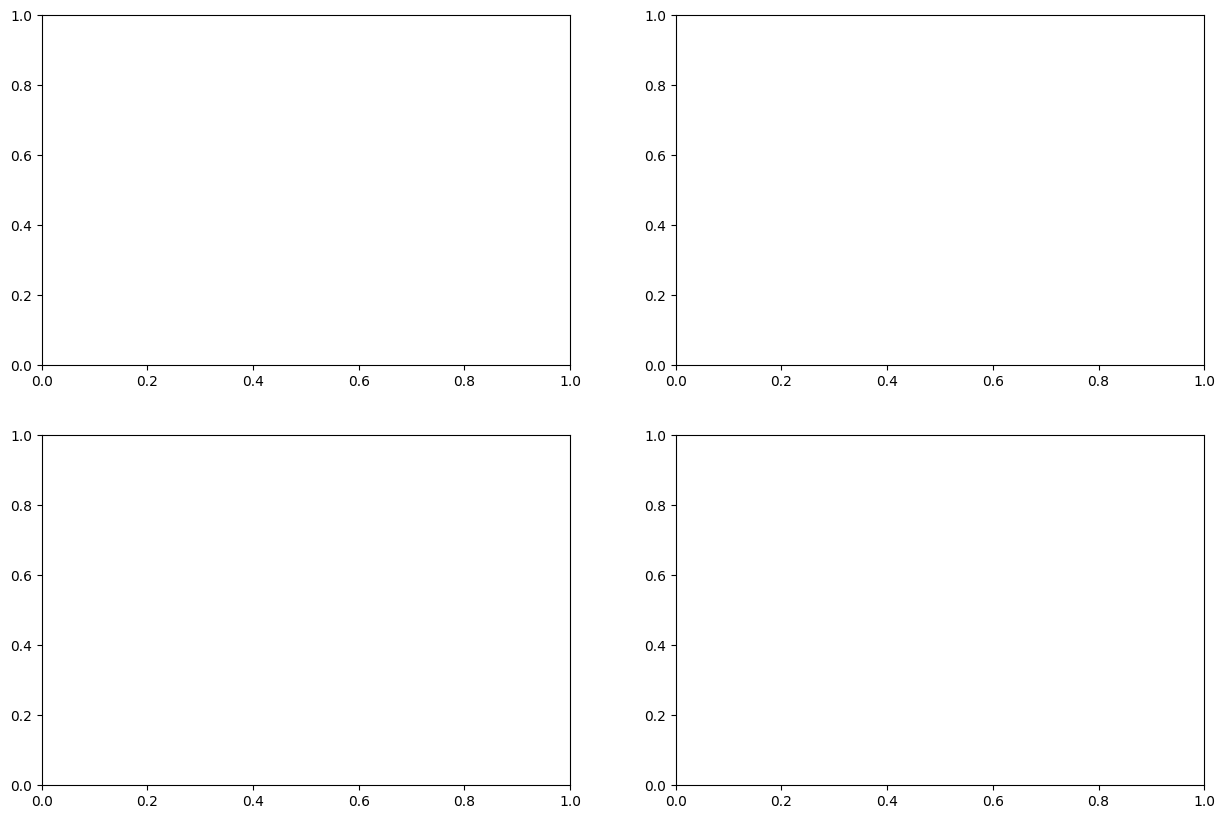

In [101]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))  # фигура с сеткой 2x2

Создадим диаграмму рассеивания, в которой по вертикальной оси будет доход в зависимости от количества покупок (горизонтальная ось), при этом цвета точек будут зависеть от возраста пользователя

In [102]:
# Scatter plot
scatter = ax1.scatter(x=dataSet['purchases'], 
                     y=dataSet['revenue'], 
                     c=dataSet['age'],
                     cmap='RdYlGn')
ax1.set_xlabel('Количество покупок')
ax1.set_ylabel('Доход')
ax1.set_title('Зависимость дохода от количества покупок')
cbar = fig.colorbar(scatter, ax=ax1)
cbar.set_label('Возраст')

Создадим гистограмму, отображающую количество пользователей в каждой возрастной группе

In [103]:
# Bar plot
ax2.bar(ageGroups.index, ageGroups.values, color=["lightgreen", "lightblue", "orange", "red"])
ax2.set_title('Распределение по возрастным группам')
ax2.set_xlabel('Возрастные группы')
ax2.set_ylabel('Количество пользователей')
pass

Создадим ящик с усами - Распределение дохода по странам

In [104]:
# Box plot
dataSet.boxplot(column='revenue', by='country', ax=ax3)
ax3.set_title('Распределение дохода по странам')
ax3.set_xlabel('Страна')
ax3.set_ylabel('Доход')
pass

Создадим круговую диаграмму, отображающую распределение пользователей по странам

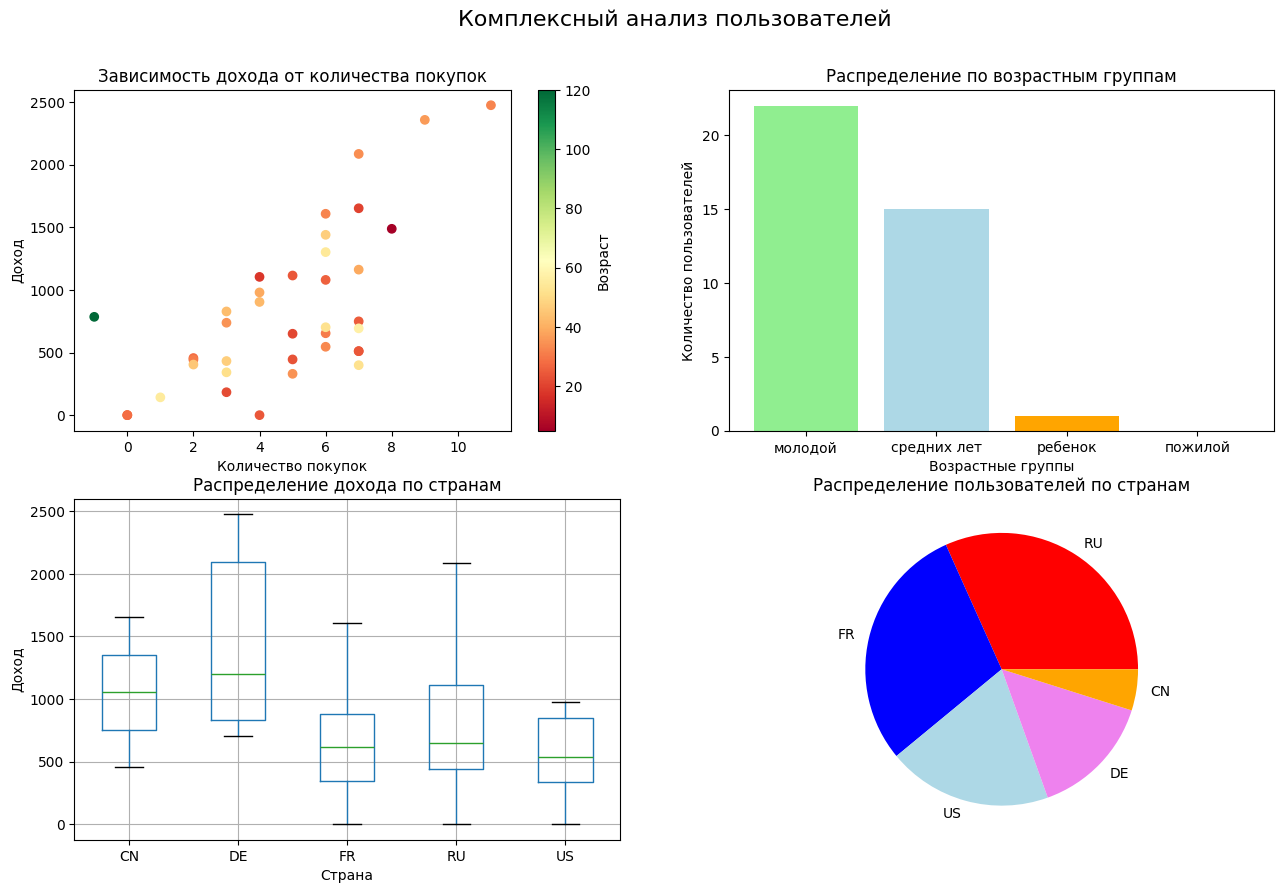

In [105]:
# Pie chart
countryCounts = dataSet['country'].value_counts()
ax4.pie(countryCounts.values, labels=countryCounts.index, 
        colors=["red", "blue", "lightblue", "violet", "orange"])
ax4.set_title('Распределение пользователей по странам')

fig.suptitle('')
fig.suptitle('Комплексный анализ пользователей', fontsize=16)
fig.savefig("./figures/my_figure.png")
display(fig)  # Вывод диаграммы